# Creating a Heatmap
### Details
- We'll be using X-Ception as the base model
- We take one of the feature outputs, and consider the gradients of our output with respect to that activation of the feature output
    - A higher gradient means the feature output is more important
- Compute the importance of each channel (mean of its gradients) in the layer's activation, then for each pixel, sum up the value of each channel times its importance
    - This means a pixel's "value" is the sum of (channel value x channel importance), meaning that the more a channel "exists" as well as how much it contributes to the final result affect the pixel's value
- We test on african elephant pictures

In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

ImportError: cannot import name 'get_config'

In [2]:
# load model & download images
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(fname="elephant.jpg", origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


AttributeError: module 'tensorflow.python.keras.api._v1.keras.utils' has no attribute 'load_img'

In [ ]:
# play around with xception & the image
plt.axis("off")
plt.imshow(img_array[0,:,:,:])

preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

In [ ]:
keras.utils.plot_model(model)

In [ ]:
# The last_conv_layer_model takes the input and gives us what the last convolutional layer's output is
last_conv_layer_name = "block14_sepconv2_act"

last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
# the classifier_model takes the output from last_conv_layer_model and turns that into a bunch of predictions
classifier_layer_names = [
    "avg_pool",
    "predictions"
]

classifier_input = keras.Input(shape=last_conv_layer.output_shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

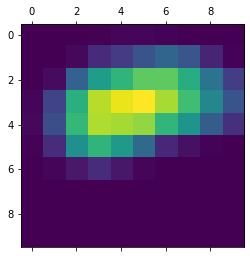

In [35]:
# okee we now create the gradients of each element of the convolutional output
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0,:])
    top_class_channel = preds[0, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

# figure out the importance of each pixel in the last_conv_layer
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy() # importance of each channel
last_conv_layer_output = last_conv_layer_output.numpy()[0] # output of the channel
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i] # channel gets multiplied by the importance
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [43]:
# get the image & hetmap
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

# the color scheme for all 256 types of colors
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]

# resize the image
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# superimpose the image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)
